In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


f:\personalProjects\multimodalHealthAssistant2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load preprocessed data from Phase 2
print("Loading preprocessed data...")

# Load the full processed dataset
df = pd.read_csv('processed_data/full_processed_df.csv')

print(f"Dataset loaded successfully:")
print(f"  - Total samples: {len(df)}")
print(f"  - Columns: {list(df.columns)}")
print(f"  - Text descriptions available: {df['text_description'].notna().sum()}")

# Display sample text descriptions
print(f"Sample text descriptions:")
for i in range(5):
    print(f"{i+1}. {df['text_description'].iloc[i]}")

# Check diagnostic distribution
print(f"Diagnostic distribution:")
print(df['diagnostic'].value_counts())


Loading preprocessed data...
Dataset loaded successfully:
  - Total samples: 2298
  - Columns: ['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed', 'age_group', 'lesion_area', 'lesion_size', 'symptom_score', 'risk_score', 'text_description']
  - Text descriptions available: 2298
Sample text descriptions:
1. 8-year-old lesion on arm
2. 55-year-old female lesion on neck risk factors: skin cancer history, cancer history
3. 77-year-old lesion on face
4. 75-year-old lesion on hand
5. 79-year-old male lesion on forearm risk factors: drink, skin cancer history
Diagnostic distribution:
diagnostic
BCC    845
ACK    730
NEV    244
SEK    235
SCC    192
MEL     52
Name: count, dtype: int64


Text description statistics:
Mean length: 54.1 characters
Median length: 61.0 characters
Min length: 24 characters
Max length: 109 characters


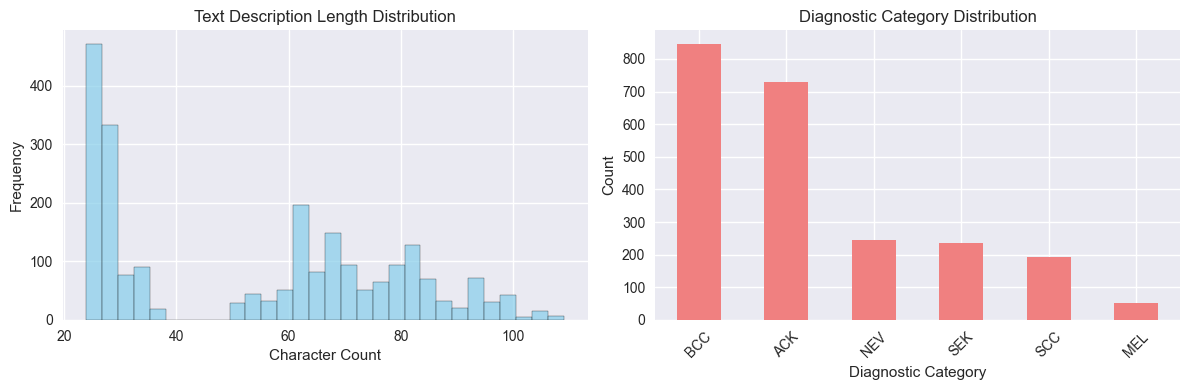


Missing text descriptions: 0


In [5]:
# Text Preprocessing and Analysis
# Analyze text description characteristics
text_lengths = df['text_description'].str.len()
print(f"Text description statistics:")
print(f"Mean length: {text_lengths.mean():.1f} characters")
print(f"Median length: {text_lengths.median():.1f} characters")
print(f"Min length: {text_lengths.min()} characters")
print(f"Max length: {text_lengths.max()} characters")

# Visualize text length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Text Description Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['diagnostic'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Diagnostic Category Distribution')
plt.xlabel('Diagnostic Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Check for missing text descriptions
missing_text = df['text_description'].isna().sum()
print(f"\nMissing text descriptions: {missing_text}")

# Fill missing descriptions with a default
if missing_text > 0:
    df['text_description'] = df['text_description'].fillna('No description available')
    print("Missing descriptions filled with default text")


In [6]:
# Approach 1: TF-IDF + Dense Layer Embeddings
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size
    stop_words='english',
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

# Fit and transform text descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_description'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Convert to dense array for easier handling
tfidf_dense = tfidf_matrix.toarray()
print(f"Dense TF-IDF shape: {tfidf_dense.shape}")

# Create a simple dense layer to reduce dimensionality
class TFIDFEmbedder(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(TFIDFEmbedder, self).__init__()
        self.linear = nn.Linear(input_dim, embedding_dim)
        self.dropout = nn.Dropout(0.1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.dropout(x)
        x = self.activation(x)
        return x

# Create TF-IDF embedder
tfidf_embedder = TFIDFEmbedder(input_dim=tfidf_dense.shape[1], embedding_dim=128)

# Convert to tensor and get embeddings
with torch.no_grad():
    tfidf_tensor = torch.FloatTensor(tfidf_dense)
    tfidf_embeddings = tfidf_embedder(tfidf_tensor).numpy()

print(f"TF-IDF embeddings shape: {tfidf_embeddings.shape}")
print("TF-IDF embeddings created successfully!")


TF-IDF matrix shape: (2298, 233)
Vocabulary size: 233
Dense TF-IDF shape: (2298, 233)
TF-IDF embeddings shape: (2298, 128)
TF-IDF embeddings created successfully!


In [7]:
# Approach 2: BERT/MiniLM Embeddings
# Load pre-trained BERT model (using a smaller, faster model)
model_name = "sentence-transformers/all-MiniLM-L6-v2"
print(f"Loading model: {model_name}")

try:
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    print("Model loaded successfully!")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Function to get embeddings from text
    def get_bert_embeddings(texts, batch_size=32):
        """Get BERT embeddings for a list of texts"""
        embeddings = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize batch
            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors='pt'
            )
            
            # Get embeddings
            with torch.no_grad():
                outputs = model(**inputs)
                # Use mean pooling of last hidden states
                batch_embeddings = outputs.last_hidden_state.mean(dim=1)
                embeddings.append(batch_embeddings.numpy())
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_texts)}/{len(texts)} texts...")
        
        return np.vstack(embeddings)
    
    # Get BERT embeddings for all text descriptions
    print("Generating BERT embeddings...")
    bert_embeddings = get_bert_embeddings(df['text_description'].tolist())
    
    print(f"BERT embeddings shape: {bert_embeddings.shape}")
    print("BERT embeddings created successfully!")
    
except Exception as e:
    print(f"Error loading BERT model: {e}")
    print("Falling back to TF-IDF approach only...")
    bert_embeddings = None


Loading model: sentence-transformers/all-MiniLM-L6-v2
Model loaded successfully!
Model parameters: 22,713,216
Generating BERT embeddings...
Processed 320/2298 texts...
Processed 640/2298 texts...
Processed 960/2298 texts...
Processed 1280/2298 texts...
Processed 1600/2298 texts...
Processed 1920/2298 texts...
Processed 2240/2298 texts...
BERT embeddings shape: (2298, 384)
BERT embeddings created successfully!


Analyzing TF-IDF embeddings...
Computing t-SNE for TF-IDF embeddings...
Analyzing BERT embeddings...
Computing t-SNE for BERT embeddings...


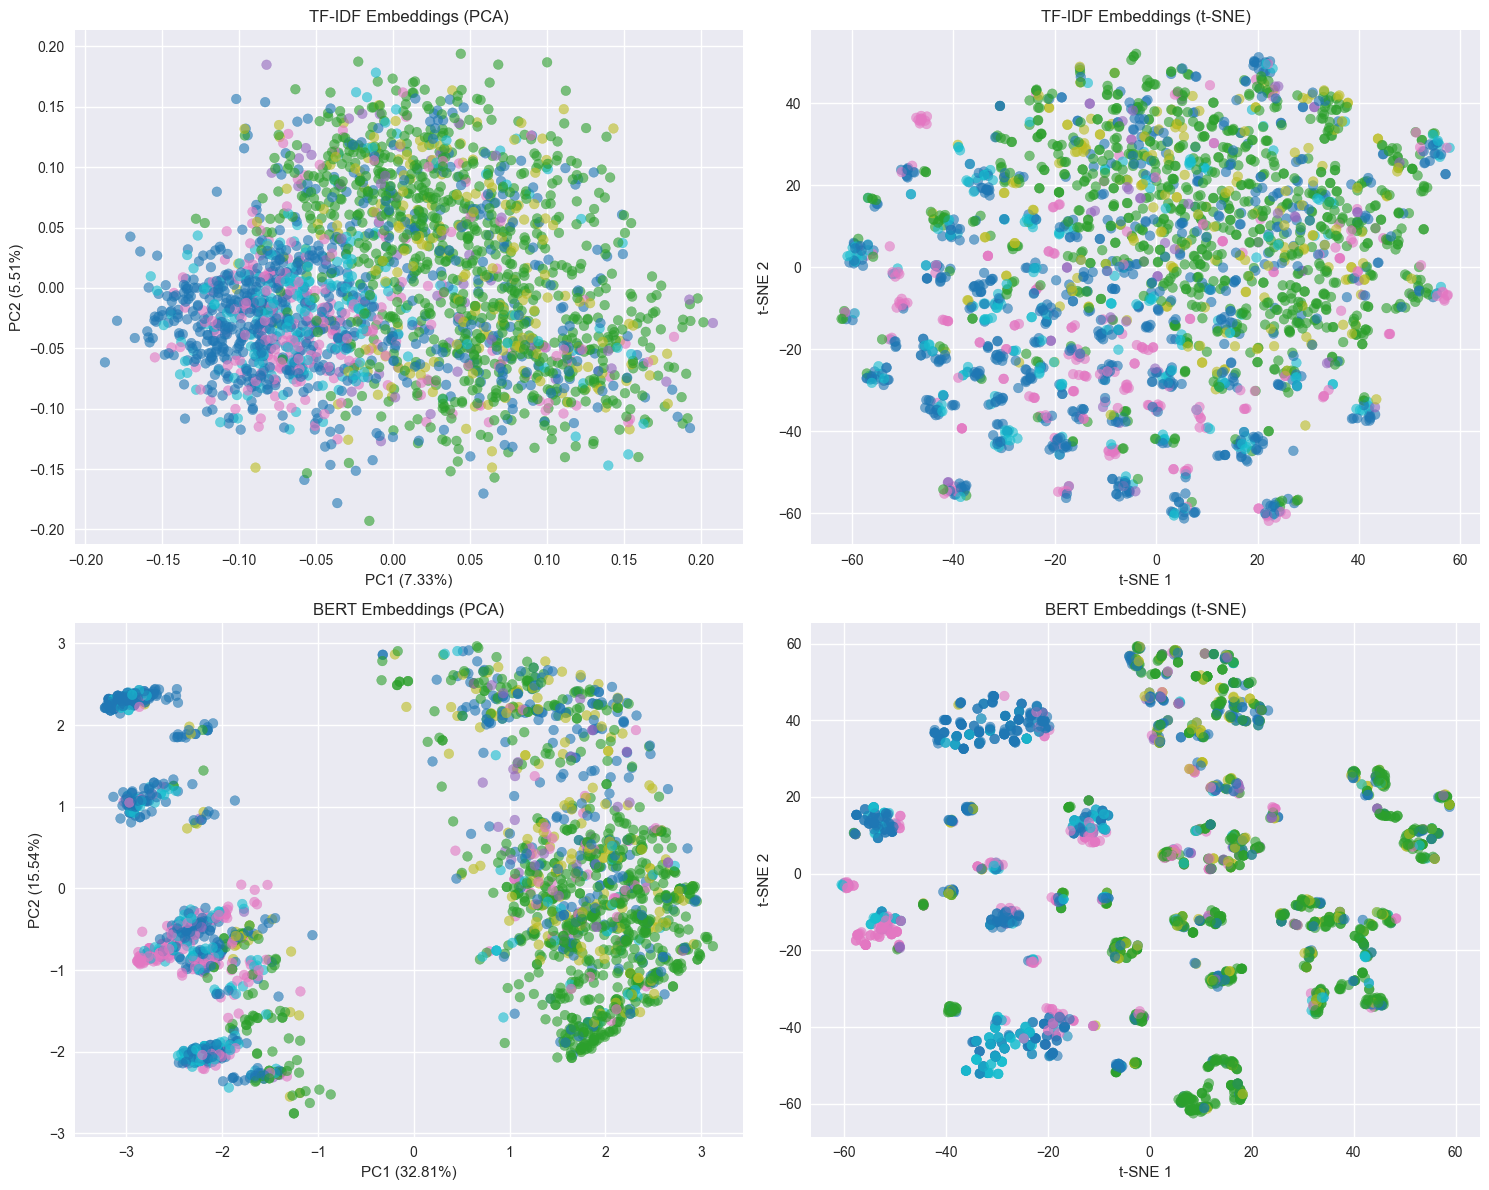

In [8]:
# Create visualizations for both embedding approaches
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# TF-IDF Embeddings Analysis
print("Analyzing TF-IDF embeddings...")

# PCA for TF-IDF embeddings
pca_tfidf = PCA(n_components=2)
tfidf_pca = pca_tfidf.fit_transform(tfidf_embeddings)

# Plot TF-IDF PCA
scatter1 = axes[0, 0].scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], 
                             c=df['diagnostic'].astype('category').cat.codes, 
                             cmap='tab10', alpha=0.6)
axes[0, 0].set_title('TF-IDF Embeddings (PCA)')
axes[0, 0].set_xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.2%})')
axes[0, 0].set_ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.2%})')

# t-SNE for TF-IDF embeddings
print("Computing t-SNE for TF-IDF embeddings...")
tsne_tfidf = TSNE(n_components=2, random_state=42, perplexity=30)
tfidf_tsne = tsne_tfidf.fit_transform(tfidf_embeddings)

# Plot TF-IDF t-SNE
scatter2 = axes[0, 1].scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], 
                             c=df['diagnostic'].astype('category').cat.codes, 
                             cmap='tab10', alpha=0.6)
axes[0, 1].set_title('TF-IDF Embeddings (t-SNE)')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')

# BERT Embeddings Analysis

print("Analyzing BERT embeddings...")
    
# PCA for BERT embeddings
pca_bert = PCA(n_components=2)
bert_pca = pca_bert.fit_transform(bert_embeddings)
    
# Plot BERT PCA
scatter3 = axes[1, 0].scatter(bert_pca[:, 0], bert_pca[:, 1], 
                                 c=df['diagnostic'].astype('category').cat.codes, 
                                 cmap='tab10', alpha=0.6)
axes[1, 0].set_title('BERT Embeddings (PCA)')
axes[1, 0].set_xlabel(f'PC1 ({pca_bert.explained_variance_ratio_[0]:.2%})')
axes[1, 0].set_ylabel(f'PC2 ({pca_bert.explained_variance_ratio_[1]:.2%})')
    
# t-SNE for BERT embeddings
print("Computing t-SNE for BERT embeddings...")
tsne_bert = TSNE(n_components=2, random_state=42, perplexity=30)
bert_tsne = tsne_bert.fit_transform(bert_embeddings)
    
# Plot BERT t-SNE
scatter4 = axes[1, 1].scatter(bert_tsne[:, 0], bert_tsne[:, 1], 
                                 c=df['diagnostic'].astype('category').cat.codes, 
                                 cmap='tab10', alpha=0.6)
axes[1, 1].set_title('BERT Embeddings (t-SNE)')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [9]:
import os
import numpy as np

# Ensure embeddings directory exists
os.makedirs('embeddings', exist_ok=True)

# Save BERT embeddings
np.save('embeddings/bert_embeddings.npy', bert_embeddings)
print(f"BERT embeddings saved at: embeddings/bert_embeddings.npy")



BERT embeddings saved at: embeddings/bert_embeddings.npy


In [10]:
np.save('embeddings/tfidf_embeddings.npy', tfidf_embeddings)

In [11]:
import pickle
import os

# Ensure embeddings folder exists
os.makedirs('embeddings', exist_ok=True)

# Save the trained TF-IDF vectorizer
with open('embeddings/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [ ]:
# with open('embeddings/bert_vectorizer.pkl', 'wb') as f:
#     pickle.dump()